# Importing Libraries

In [52]:
import matplotlib.pyplot as plt
from custom_fcn import *
from resnet_34_fcn import *
import torch
from torchvision import transforms
import torchvision.transforms as standard_transforms
from torch.utils.data import DataLoader
from voc import VOC
import voc
import numpy as np

# Mapping Class to Color

In [53]:
'''
color map
0=background, 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle # 6=bus, 7=car, 8=cat, 9=chair, 10=cow, 11=diningtable,
12=dog, 13=horse, 14=motorbike, 15=person # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
'''

noToClass = {
    0:"background", 1:"aeroplane", 2:"bicycle", 3:"bird", 4:"boat", 5:"bottle", 6:"bus", 7:"car", 8:"cat", 9:"chair", 10:"cow", 11:"dining table",
12:"dog", 13:"horse", 14:"motorbike", 15:"person", 16:"potted plant", 17:"sheep", 18:"sofa", 19:"train", 20:"tv/monitor"
}

palette = [0, 0, 0, 128, 0, 0, 0, 128, 0, 128, 128, 0, 0, 0, 128, 128, 0, 128, 0, 128, 128,
           128, 128, 128, 64, 0, 0, 192, 0, 0, 64, 128, 0, 192, 128, 0, 64, 0, 128, 192, 0, 128,
           64, 128, 128, 192, 128, 128, 0, 64, 0, 128, 64, 0, 0, 192, 0, 128, 192, 0, 0, 64, 128]  #3 values- R,G,B for every class. First 3 values for class 0, next 3 for

"""
    TODO Convert palette to map class number to RGB color.

    Expected output, python dictionary with 21 integer keys, each value being a array of size 3

"""
category_RGC_dict = dict()

for category in noToClass.keys():
    category_RGC_dict[category] = palette[category*3:category*3+3]

print(category_RGC_dict)
palette = category_RGC_dict
print(palette.items())

{0: [0, 0, 0], 1: [128, 0, 0], 2: [0, 128, 0], 3: [128, 128, 0], 4: [0, 0, 128], 5: [128, 0, 128], 6: [0, 128, 128], 7: [128, 128, 128], 8: [64, 0, 0], 9: [192, 0, 0], 10: [64, 128, 0], 11: [192, 128, 0], 12: [64, 0, 128], 13: [192, 0, 128], 14: [64, 128, 128], 15: [192, 128, 128], 16: [0, 64, 0], 17: [128, 64, 0], 18: [0, 192, 0], 19: [128, 192, 0], 20: [0, 64, 128]}
dict_items([(0, [0, 0, 0]), (1, [128, 0, 0]), (2, [0, 128, 0]), (3, [128, 128, 0]), (4, [0, 0, 128]), (5, [128, 0, 128]), (6, [0, 128, 128]), (7, [128, 128, 128]), (8, [64, 0, 0]), (9, [192, 0, 0]), (10, [64, 128, 0]), (11, [192, 128, 0]), (12, [64, 0, 128]), (13, [192, 0, 128]), (14, [64, 128, 128]), (15, [192, 128, 128]), (16, [0, 64, 0]), (17, [128, 64, 0]), (18, [0, 192, 0]), (19, [128, 192, 0]), (20, [0, 64, 128])])


# Transformations to be done on images

In [54]:
class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()

# TODO Rewrite the following transformations to the ones your models are trained on.
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])

target_transform = MaskToTensor()

# Getting random test image and mask

In [55]:
batch_size = 1
DS = voc.VOC('test', transform=input_transform, target_transform=target_transform)
DL = DataLoader(dataset=DS, batch_size= 1, shuffle=False)

first_batch = iter(DL)

In [64]:
img, msk = next(first_batch)

# Plotting Function

In [65]:
def makeImagesPlotReady(msk, channels = 3):
    """
    TODO 
    Similar to how you converted the images, make the mask tensor matplotlib ready

    args:
        msk or img - input mask tensor of shape [1, 3, 224, 224] or numpy of shape (3, 224, 224)
    returns:
        mask/img - mask that is ready to be plotted using matplotlib.
                    Hint: Numpy class of shape (224, 224, 3)
    """
    if isinstance(msk, torch.Tensor):
        mask_numpy_array = msk.permute(0, 2, 3, 1).squeeze().numpy()
    else: 
        mask_numpy_array = np.transpose(msk, (1, 2, 0))
    print(type(mask_numpy_array))
    print(mask_numpy_array.shape)
    return mask_numpy_array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'>
(224, 224, 3)


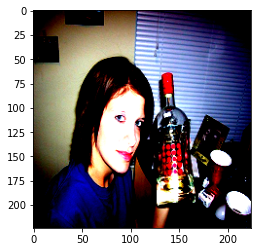

In [66]:
# Check your makeImagesPlotReady implementation by printing the img variable
plt.imshow(makeImagesPlotReady(img,3))

In [67]:
np.max(msk.numpy())

15

### Preprocessing msk

In [68]:
# msk = (msk*255).int()
msk[msk==255]=0

In [69]:
# def convertMaskToRGB(msk_1d):
#     print("mask_1d shape",msk_1d.shape)
#     mask_rgb = np.zeros((3, 224, 224), dtype=np.uint8) # Empty array to store RGB of each class
        
#     for idx, color in palette.items(): # Converting to colors
#         for j in range(3): # R,G,B
#             mask_rgb[j][msk_1d[0] == idx] = color[j]
#             mask_rgb[j][msk_1d[0] == idx] = color[j]
#             mask_rgb[j][msk_1d[0] == idx] = color[j]

#     return mask_rgb

def convertMaskToRGB(msk_1d):
    print("mask_1d shape",msk_1d.shape)
    mask_rgb = np.zeros((3, 224, 224), dtype=np.uint8) # Empty array to store RGB of each class
    
    for x in range(224):
        for y in range(224):
            mask_label = msk_1d[0][x][y].item()
            # print(mask_label)
            for j in range(3): # R,G,B
                mask_rgb[j][x][y] = palette[mask_label][j]
                
                
    return mask_rgb
        
#     for idx, color in palette.items(): # Converting to colors
#         print("here")
#         print(idx)
#         print(color)
#         print(msk_1d == idx)
#         for j in range(3): # R,G,B
#             for x in range(224):
#                 for y in range(224):
                    
            
#             mask_rgb[j][msk_1d == idx] = color[j]


# Plotting single mask

mask_1d shape torch.Size([1, 224, 224])
<class 'numpy.ndarray'>
(224, 224, 3)


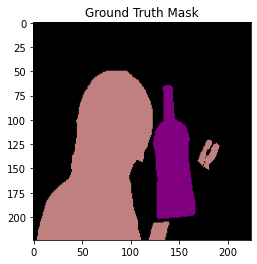

In [70]:
# Check your makeImagesPlotReady implementation by printing the msk variable
mask_rgb = convertMaskToRGB(msk)
plt.imshow(makeImagesPlotReady(mask_rgb,3))
plt.title("Ground Truth Mask")
plt.show()

# Running Inference on all trained models

In [71]:
"""
TODO:
The following comments are what we suggest your final 
code structure should look like for streamlined inference.
"""

# Importing all Question train files.
# import train
# import train_4_a
# import train_4_b
# import train_4_c
# import train_5_a
# import train_5_b
# import train_5_c
# numberOfModels = 7
# models = ["train", "train_4_a", "train_4_b", "train_4_c", "train_5_a", "train_5_b", "train_5_c"]

train_baseline = torch.load("/home/sgaywala/private/PA2/model_baseline.pt")
train_4a = torch.load("/home/sgaywala/private/PA2/model_4a.pt")
train_4b = torch.load("/home/sgaywala/private/PA2/model_4b.pt")
train_4c = torch.load("/home/sgaywala/private/PA2/model_4c.pt")
train_5a = torch.load("/home/sgaywala/private/PA2/model_5a.pt")
train_5b = torch.load("/home/sgaywala/private/PA2/model_5b.pt")
models = ["train_baseline", "train_4a", "train_4b", "train_4c", "train_5a", "train_5b"]
models_dict = {"train_baseline" : train_baseline,
              "train_4a" : train_4a,
              "train_4b": train_4b,
              "train_4c" : train_4c,
              "train_5a" : train_5a,
              "train_5b" : train_5b}
numberOfModels = 6

In [72]:
def exportModel(inputs, fcn_model):    
    """
    Export the output of the model for given inputs.

    - Set the model to evaluation mode.
    - Load the model with the best saved weights.
    - Perform a forward pass with the model to get output.
    - Switch model back to training mode.

    Args:
        inputs: Input data to the model.

    Returns:
        Output from the model for the given inputs.
    """
    device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
    fcn_model.eval() # Put in eval mode (disables batchnorm/dropout) !
    
    inputs = inputs.to(device)
    
    output_image = fcn_model(inputs)
    
    fcn_model.train()  #TURNING THE TRAIN MODE BACK ON TO ENABLE BATCHNORM/DROPOUT!!
    
    return output_image

In [73]:
def returnToString(arr):
    string = ""
    for i in arr:
        string += noToClass[i]
        string += ", "
    return string[:-2]

In [74]:
import torch
import numpy as np
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


print("GROUND TRUTH CLASSES:", torch.unique(msk),"\n")

output_images = []
for model in models:
    print("Inferring Model:",model)
#     output_image = eval(model).exportModel(img) # Run inference (Make sure exportModel function is imported for each train file)
    output_image = exportModel(img, models_dict[model])
    output_image = output_image.to("cpu").detach() # Remove torch components and push to cpu
    output_image = torch.argmax(output_image, dim=1) # converting softmax to OHE
    print("Model Predicted Classes:", returnToString(torch.unique(output_image).numpy()))

    mask_rgb = convertMaskToRGB(output_image)
    
    output_images.append(mask_rgb)
    

GROUND TRUTH CLASSES: tensor([ 0,  5, 15]) 

Inferring Model: train_baseline
Model Predicted Classes: background, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_4a
Model Predicted Classes: background, motorbike, person, potted plant
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_4b
Model Predicted Classes: background, bottle, bus, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_4c
Model Predicted Classes: background
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_5a
Model Predicted Classes: background, person
mask_1d shape torch.Size([1, 224, 224])
Inferring Model: train_5b
Model Predicted Classes: background, person
mask_1d shape torch.Size([1, 224, 224])


# Plotting All outputs

## Plotting only predicted masks

Prediction Masks
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)


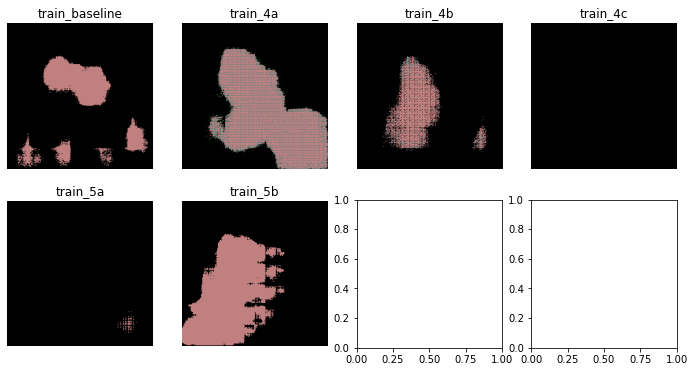

In [75]:
print("Prediction Masks")
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(numberOfModels):
    axs[i].imshow(makeImagesPlotReady(output_images[i],3))
    axs[i].set_title(models[i])
    axs[i].axis('off')

plt.show()

## Plotting image with the mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction Masks
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)
<class 'numpy.ndarray'>
(224, 224, 3)


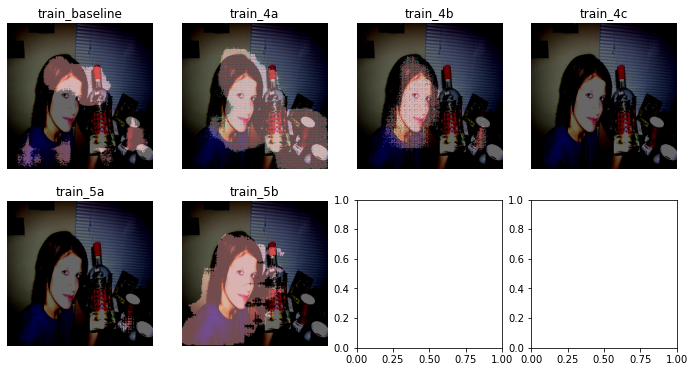

In [76]:
print("Prediction Masks")
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
axs = axs.flatten()
for i in range(numberOfModels):
    axs[i].imshow(makeImagesPlotReady(img,3))
    axs[i].imshow(makeImagesPlotReady(output_images[i],3), alpha = 0.6)
    axs[i].set_title(models[i])
    axs[i].axis('off')

plt.show()